# Testes sobre o algoritmo Multilayer Perceptron
<p>O objetivo é desenvolver uma rede neural MLP que seja capaz de prever um carater. Nesse estudo, será verificado a influência do uso das funções de custo MSE e CrossEntropy, além de analisar o efeito do uso de cross validation e early stopping. Além disso, para busca de hiperparamêtros, será feito uma random search.</p>
<p>Serão analisadas as seguintes funções de ativação:</p>
- Softmax
- Sigmoid
- ReLU
- Tanh

### Dataset CARACTERES_COMPLETO
<p>X.txt -> Contém os valores dos 120pixels de cada imagem de Letra</p>
<p>Y_letra -> Contém a target do dado</p>
<p>Há 1326 exemplares</p>

In [1]:
import os
import numpy as np

In [5]:
def load_data(path):
    data = []
    with open(path, "r") as file:
        for line in file:
            values = [val.strip() for val in line.strip().split(",") if val.strip() != ""]
            if values:
                data.append([float(v) for v in values])
    return np.array(data, dtype=float)

In [6]:
#path do conjunto de dados
base_dir = os.getcwd()
X_txt_path = os.path.join(base_dir, "..", "CARACTERES_COMPLETO", "X.txt")
Y_txt_path = os.path.join(base_dir, "..", "CARACTERES_COMPLETO", "Y_letra.txt")

In [7]:
X = load_data(X_txt_path)

In [8]:
# Verifica a existência de dados faltantes
comprimentos = [len(linha) for linha in X]
if len(set(comprimentos)) > 1:
    raise ValueError(f"Linhas com tamanhos diferentes detectadas: {set(comprimentos)}")

In [9]:
X

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

<p>Analisando os valores, não é necessário a normalização, pois todas as features estão na mesma escala aproximadamente.</p>

In [10]:
with open(Y_txt_path, "r") as file:
    letters = [line.strip() for line in file]
letter_to_index = {chr(i + 65): i for i in range(26)}
Y = np.array([letter_to_index[l] for l in letters])
n_classes = 26

In [11]:
unique, counts = np.unique(Y, return_counts=True)
index_to_letter = {i: chr(i+65) for i in range(26)}
labels = [index_to_letter[i] for i in unique]

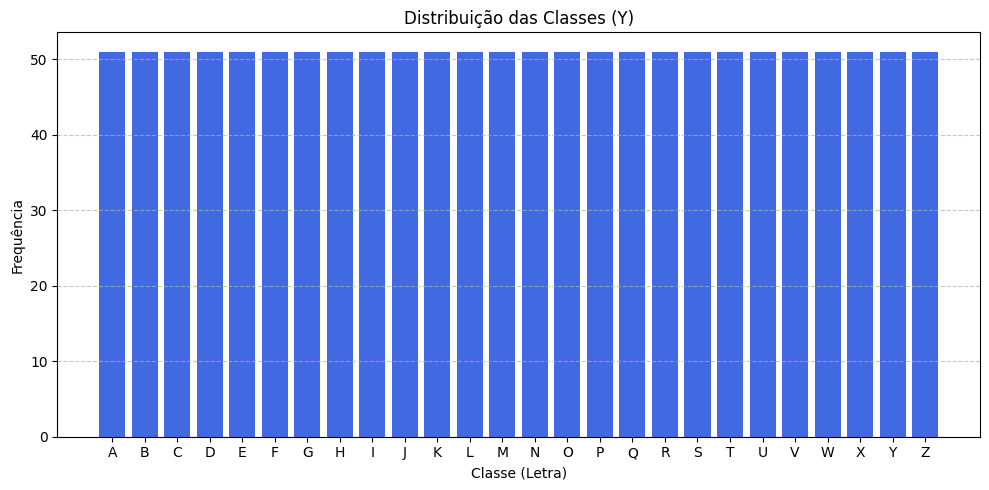

In [12]:
import matplotlib.pyplot as plt

#Gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='royalblue')
plt.xlabel("Classe (Letra)")
plt.ylabel("Frequência")
plt.title("Distribuição das Classes (Y)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<p>Conforme o gráfico de barras, o dataset é balanceado em termos da quantidade de classes. Portanto, a acurácia é uma métrica confiável</p>

In [13]:
# One-hot encoding
y = np.zeros((len(Y), n_classes))
y[np.arange(len(Y)), Y] = 1

### Random Search
<p>Primeiramente, será feito um estudo dos hiperparamêtros para encontrar a melhor configuração. Após encontrar tal configuração, será estudado os quatro cenários propostos pela Professora. Será feito com Validation Cruzada, para evitar o overfitting.</p>

In [14]:
def accurancy(predictions, targets):
    predicted_classes = np.argmax(predictions, axis=1)
    real_classes = np.argmax(targets, axis=1)
    return np.mean(predicted_classes == real_classes)

In [15]:
import sys
sys.path.append("../../WORKIA")

In [16]:
from MLP.mlp import MLP
from MLP.trainer import *
from MLP.losses.loss_crossentropy import LossCrossEntropy 
from MLP.losses.loss_mse import LossMSE
from MLP.activation_functions.ReLU import ReLU
from MLP.activation_functions.sigmoid import Sigmoid
from MLP.activation_functions.softmax import Softmax
from MLP.activation_functions.tanh import Tanh
from MLP.activation_functions.ELU import ELU
from MLP.activation_functions.leakyReLU import LeakyReLU
import itertools
import random

def random_searchMLP(grid, X, y, loss, n_samples=20):
    all_combinations = list(itertools.product(
        grid['n_neurons'],
        grid['activation_hidden'],
        grid['activation_output'],
        grid['learning_rate'],
        grid['epochs']
    ))
    samples = random.sample(all_combinations, n_samples)
    metrics = []
    for combination in samples:
        n_neurons, act_hidden, act_output, lr, epochs = combination
        trainer = BackPropagationCV(loss, lr, epochs)
        configs = [
            (n_neurons, X.shape[1], act_hidden),
            (y.shape[1], n_neurons, act_output)
        ]
        model = MLP(configs, trainer)
        results = model.train(X, y, k=5)
        rs = []
        for result in results:
            rs.append(accurancy(result['predictions'], result['targets']))
        acc = np.mean(rs) #Acurácia média
        std = np.std(rs) #Desvio padrão
        metrics.append({
            'n_neurons': n_neurons,
            'activation_hidden': act_hidden.getName(),
            'activation_output': act_output.getName(),
            'learning_rate': lr,
            'epochs': epochs,
            'accurancy': acc,
            'std': std
        })
    return metrics

In [17]:
grid = {
    'n_neurons': [16, 32, 64],
    'activation_hidden': [ReLU(), LeakyReLU(alpha=0.01), ELU(alpha=1.0)],
    'activation_output': [Sigmoid(), Tanh()],
    'learning_rate': [0.01, 0.05, 0.15],
    'epochs': [250, 500, 1000]
}

In [18]:
X_train = X[:-130]
y_train = y[:-130]
X_test = X[-130:]
y_test = y[-130:]

In [19]:
metrics = random_searchMLP(grid, X_train, y_train, LossMSE(), 40)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 500
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 32 neurons - Activation: ELU
  Layer 2: 26 neurons - Activation: Sigmoid

Epoch 1/500 - Loss: 0.249978
Epoch 100/500 - Loss: 0.037967
Epoch 200/500 - Loss: 0.037516
Epoch 300/500 - Loss: 0.037350
Epoch 400/500 - Loss: 0.037259
Epoch 500/500 - Loss: 0.037195
Epoch 1/500 - Loss: 0.214582
Epoch 100/500 - Loss: 0.037937
Epoch 200/500 - Loss: 0.037487
Epoch 300/500 - Loss: 0.037321
Epoch 400/500 - Loss: 0.037227
Epoch 500/500 - Loss: 0.037158
Epoch 1/500 - Loss: 0.188977
Epoch 100/500 - Loss: 0.037797
Epoch 200/500 - Loss: 0.037418
Epoch 300/500 - Loss: 0.037267
Epoch 400/500 - Loss: 0.037175
Epoch 500/500 - Loss: 0.037103
Epoch 1/500 - Loss: 0.167167
Epoch 100/500 - Loss: 0.037670
Epoch 200/500 - Loss: 0.037355
Epoch 300/500 - Loss: 0.037226
Epoch 400/500 - Loss: 0.037150
Epoch 500/500 - Loss: 0.037093
Epoch 1/500 - Loss: 0.149679
Epoc

In [20]:
import pandas as pd
import seaborn as sns

def plot_accuracy_heatmap(metrics, x_label, y_label):
    # Crie um DataFrame com as métricas para fácil manipulação
    accuracy_data = []
    
    for metric in metrics:
        row = [
            metric['n_neurons'],
            metric['activation_hidden'],
            metric['activation_output'],
            metric['learning_rate'],
            metric['epochs'],
            metric['accurancy'],
            metric['std']
        ]
        accuracy_data.append(row)

    accuracy_df = pd.DataFrame(accuracy_data, columns=['n_neurons', 'activation_hidden', 'activation_output', 'learning_rate', 'epochs', 'accurancy', 'std'])

    
    accuracy_df['annot'] = accuracy_df['accurancy'].round(2).astype(str) + '±' + accuracy_df['std'].round(2).astype(str)

    # Pivot com agregação (caso hajam duplicatas)
    heatmap_data = accuracy_df.pivot_table(
        index=y_label,
        columns=x_label,
        values='accurancy',
        aggfunc='mean'  # ou np.mean
    )

    # Nova forma: calcule a média e o desvio padrão diretamente
    mean_df = accuracy_df.pivot_table(index=y_label, columns=x_label, values='accurancy', aggfunc='mean')
    std_df = accuracy_df.pivot_table(index=y_label, columns=x_label, values='std', aggfunc='mean')

    # Formata a anotação com base nas médias reais
    annot_data = mean_df.round(2).astype(str) + '±' + std_df.round(2).astype(str)

    # Plote a matriz de acurácia com um heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=annot_data, cmap='viridis', fmt='', cbar_kws={'label': 'Acurácia Média'})
    plt.title('Média ± Desvio Padrão da Acurácia')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

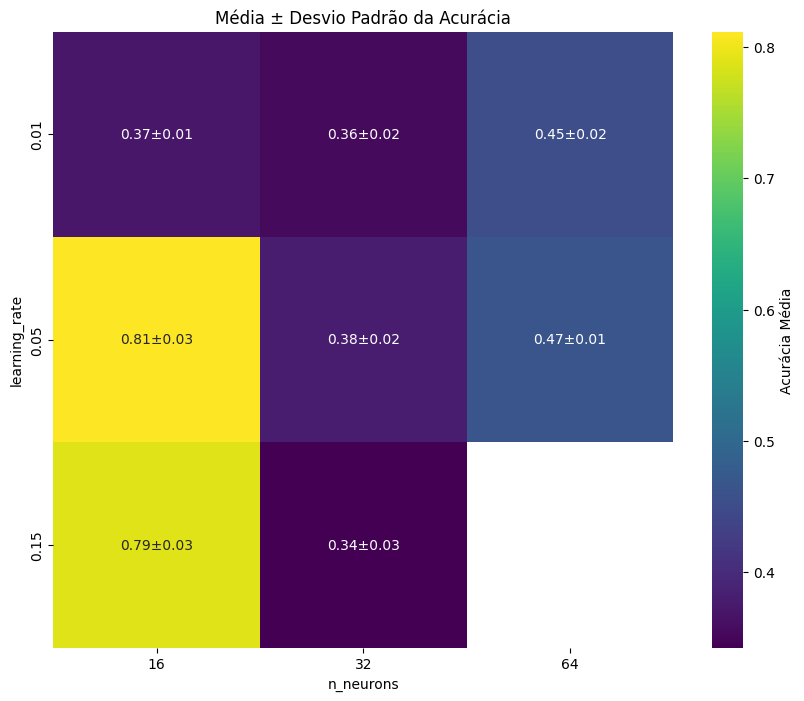

In [21]:
plot_accuracy_heatmap(metrics,'n_neurons', 'learning_rate')

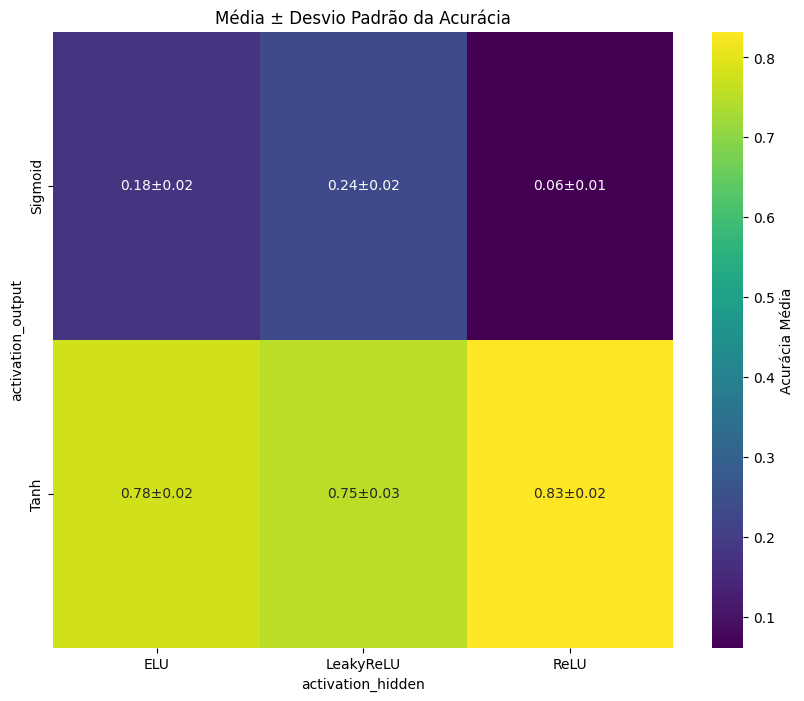

In [22]:
plot_accuracy_heatmap(metrics,'activation_hidden', 'activation_output')

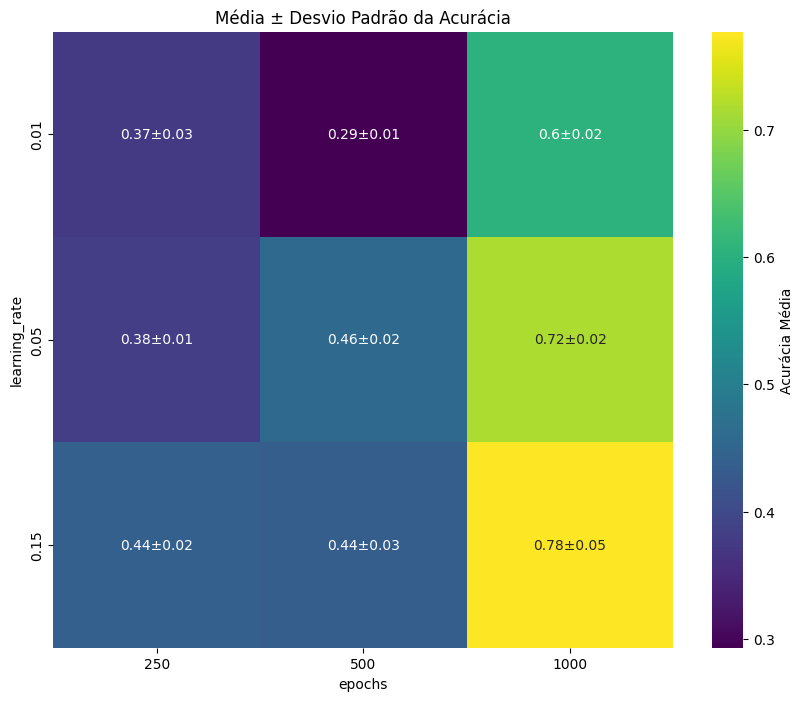

In [23]:
plot_accuracy_heatmap(metrics,'epochs', 'learning_rate')

In [24]:
df = pd.DataFrame(metrics)
id = df['accurancy'].idxmax()
print(df.loc[id])

n_neurons                  64
activation_hidden        ReLU
activation_output        Tanh
learning_rate            0.05
epochs                   1000
accurancy             0.88547
std                  0.014148
Name: 30, dtype: object


<p>De acordo com os resultados, percebe-se que a melhor configuração de hiperparamêtros é: </p>


### Análise do uso de Cross Validation e Early Stopping

#### Sem Validação Cruzada e Early Stopping

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
def get_confusion_matrix(predictions, targets, class_labels):
    y_true = np.argmax(targets, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    c_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.title("Matriz de Confusão")
    plt.show()

In [28]:
better_params = df.loc[id]
better_params['n_neurons']

64

In [29]:
configs = [
    (better_params['n_neurons'], X_train.shape[1], ReLU()),
    (y_train.shape[1], better_params['n_neurons'], Tanh())
]
model = MLP(
    configs,
    BackPropagation(LossMSE(), better_params['learning_rate'], better_params['epochs'])
)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: ReLU
  Layer 2: 26 neurons - Activation: Tanh



In [30]:
model.train(X_train, y_train)

Epoch 1/1000 - Loss: 0.038587
Epoch 100/1000 - Loss: 0.029193
Epoch 200/1000 - Loss: 0.024136
Epoch 300/1000 - Loss: 0.021071
Epoch 400/1000 - Loss: 0.018839
Epoch 500/1000 - Loss: 0.016917
Epoch 600/1000 - Loss: 0.015257
Epoch 700/1000 - Loss: 0.013882
Epoch 800/1000 - Loss: 0.012757
Epoch 900/1000 - Loss: 0.011830
Epoch 1000/1000 - Loss: 0.011055


In [31]:
y_pred = model.predict(X_test)

In [32]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7923076923076923


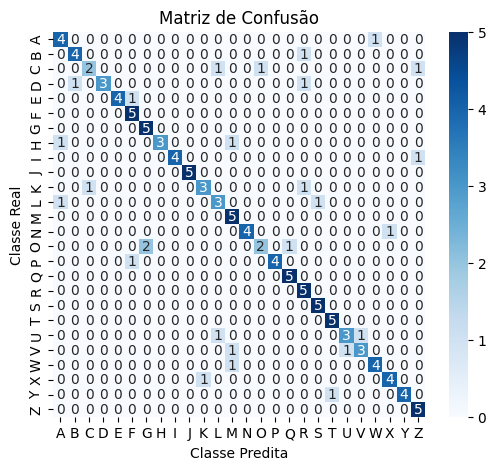

In [33]:
get_confusion_matrix(y_pred, y_test, labels)

### Com Validação cruzada

In [34]:
model = MLP(
    configs,
    BackPropagationCV(LossMSE(), better_params['learning_rate'], better_params['epochs'])
)

results = model.train(X_train, y_train, k=5)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: ReLU
  Layer 2: 26 neurons - Activation: Tanh

Epoch 1/1000 - Loss: 0.038585
Epoch 100/1000 - Loss: 0.029018
Epoch 200/1000 - Loss: 0.024002
Epoch 300/1000 - Loss: 0.021021
Epoch 400/1000 - Loss: 0.018637
Epoch 500/1000 - Loss: 0.016591
Epoch 600/1000 - Loss: 0.014864
Epoch 700/1000 - Loss: 0.013390
Epoch 800/1000 - Loss: 0.012174
Epoch 900/1000 - Loss: 0.011167
Epoch 1000/1000 - Loss: 0.010316
Epoch 1/1000 - Loss: 0.039169
Epoch 100/1000 - Loss: 0.028655
Epoch 200/1000 - Loss: 0.023831
Epoch 300/1000 - Loss: 0.020886
Epoch 400/1000 - Loss: 0.018574
Epoch 500/1000 - Loss: 0.016536
Epoch 600/1000 - Loss: 0.014825
Epoch 700/1000 - Loss: 0.013439
Epoch 800/1000 - Loss: 0.012325
Epoch 900/1000 - Loss: 0.011412
Epoch 1000/1000 - Loss: 0.010658
Epoch 1/1000 - Loss: 0.042457
Epoch 100/1000 - Loss: 0.029299
Epoch 

In [35]:
acc_avg = np.mean([accurancy(rs['predictions'], rs['targets']) for rs in results])
acc_avg

0.8978632478632479

In [36]:
y_pred = model.predict(X_test)

In [37]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7692307692307693


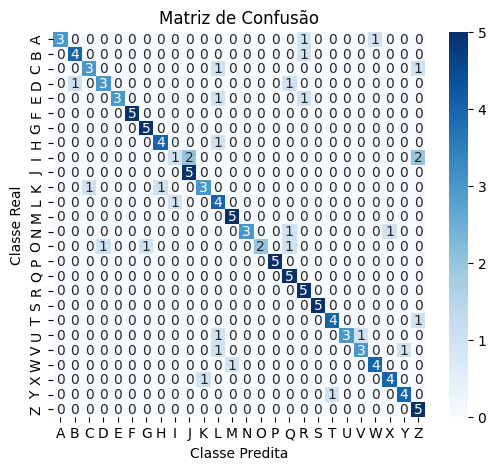

In [38]:
get_confusion_matrix(y_pred, y_test, labels)

### Com Early Stopping

In [39]:
model = MLP(
    configs,
    BackPropagationES(LossMSE(), better_params['learning_rate'], 300)
)

model.train(X_train, y_train)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 300
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: ReLU
  Layer 2: 26 neurons - Activation: Tanh

Epoch 1 - Loss: 0.038596
Epoch 100 - Loss: 0.028999
Epoch 200 - Loss: 0.024072
Epoch 300 - Loss: 0.020923
Epoch 400 - Loss: 0.018556
Epoch 500 - Loss: 0.016546
Epoch 600 - Loss: 0.014878
Epoch 700 - Loss: 0.013553
Epoch 800 - Loss: 0.012508
Epoch 900 - Loss: 0.011662
Epoch 1000 - Loss: 0.010961
Epoch 1100 - Loss: 0.010365
Epoch 1200 - Loss: 0.009846
Melhor acurácia
Época 1277: 0.8942


In [40]:
y_pred = model.predict(X_test)

In [41]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7923076923076923


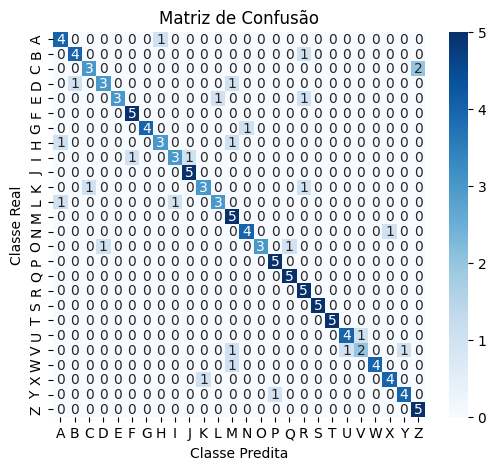

In [42]:
get_confusion_matrix(y_pred, y_test, labels)

<p>Primeiramente, ao analisar os heatmaps da random search, a função Tangente Hiperbólica com loss_MSE apresentou melhores resultados comparado a Sigmoide. Também se percebe que as funções ReLu, LeakyReLU e ELU apresentaram desempenho similar. Além disso, percebe-se que o aumento de número de épocas implica na melhoria do classificador.</p>
<p>A quantidade de neurônios na hidden layer possui um pior desempenho em 32 neurônios. 16 e 64 demonstraram ser quantidades mais promissoras, dependendo da taxa de aprendizado. Ao aumentar a taxa de aprendizado, percebe-se uma tendência de melhora.</p>

<p>Em análise, houve o mesmo desempenho em todos os testes, ocorrendo também erros comuns em todos os casos. Por exemplo, percebe-se uma tendência do modelo confudir as letras V e U. Portanto, O Early Stopping apenas ajuda o modelo convergir mais rápido e evitar um overfitting e o Cross Validation apenas auxilia na busca dos melhores hiperparamêtros e definição de arquitetura, além de fornecer métricas mais confiável. Mas tais técnicas não melhoram significativamente o desempenho do classificador.</p>

### Teste com Loss_Cross_Entropy
<p>Será analisado o efeito do uso da função de custo Cross Entropy. Para isso, se utilizará na camada de saída as funções: SoftMax e Sigmoid.</p>

In [43]:
grid = {
    'n_neurons': [16, 32, 64],
    'activation_hidden': [ReLU(), LeakyReLU(alpha=0.01), ELU(alpha=1.0)],
    'activation_output': [Sigmoid(), Softmax()],
    'learning_rate': [0.01, 0.05, 0.15],
    'epochs': [250, 500, 1000]
}

In [44]:
metrics = random_searchMLP(grid, X_train, y_train, LossCrossEntropy(), 40)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 500
Learning rate: 0.01
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: ELU
  Layer 2: 26 neurons - Activation: SoftMax

Epoch 1/500 - Loss: 3.258473
Epoch 100/500 - Loss: 3.245653
Epoch 200/500 - Loss: 3.226567
Epoch 300/500 - Loss: 3.191827
Epoch 400/500 - Loss: 3.126002
Epoch 500/500 - Loss: 3.010771
Epoch 1/500 - Loss: 3.257755
Epoch 100/500 - Loss: 3.244702
Epoch 200/500 - Loss: 3.224989
Epoch 300/500 - Loss: 3.188892
Epoch 400/500 - Loss: 3.120321
Epoch 500/500 - Loss: 2.999993
Epoch 1/500 - Loss: 3.257597
Epoch 100/500 - Loss: 3.245299
Epoch 200/500 - Loss: 3.226956
Epoch 300/500 - Loss: 3.193935
Epoch 400/500 - Loss: 3.131423
Epoch 500/500 - Loss: 3.019104
Epoch 1/500 - Loss: 3.257598
Epoch 100/500 - Loss: 3.245158
Epoch 200/500 - Loss: 3.226832
Epoch 300/500 - Loss: 3.193970
Epoch 400/500 - Loss: 3.132361
Epoch 500/500 - Loss: 3.024150
Epoch 1/500 - Loss: 3.257663
Epoc

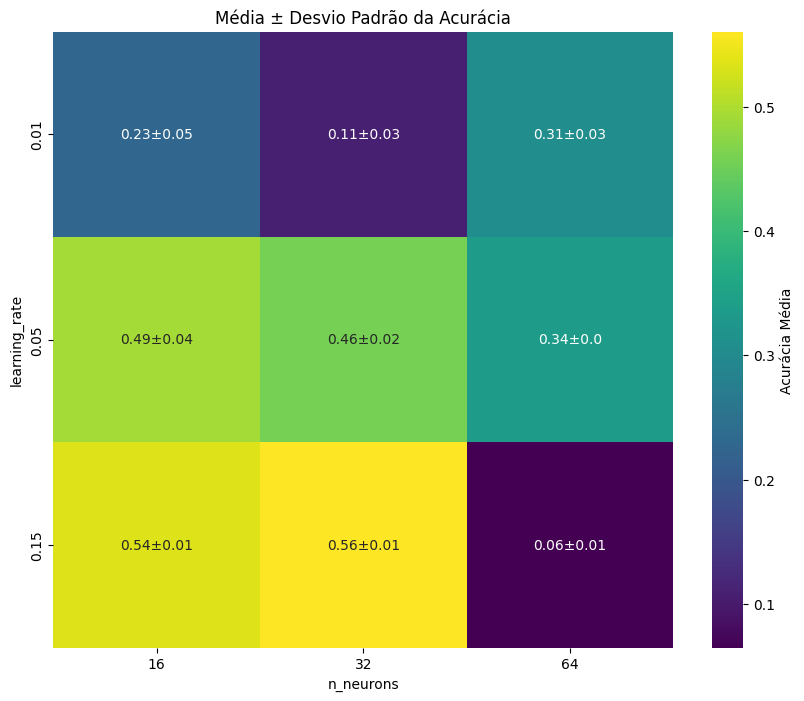

In [45]:
plot_accuracy_heatmap(metrics,'n_neurons', 'learning_rate')

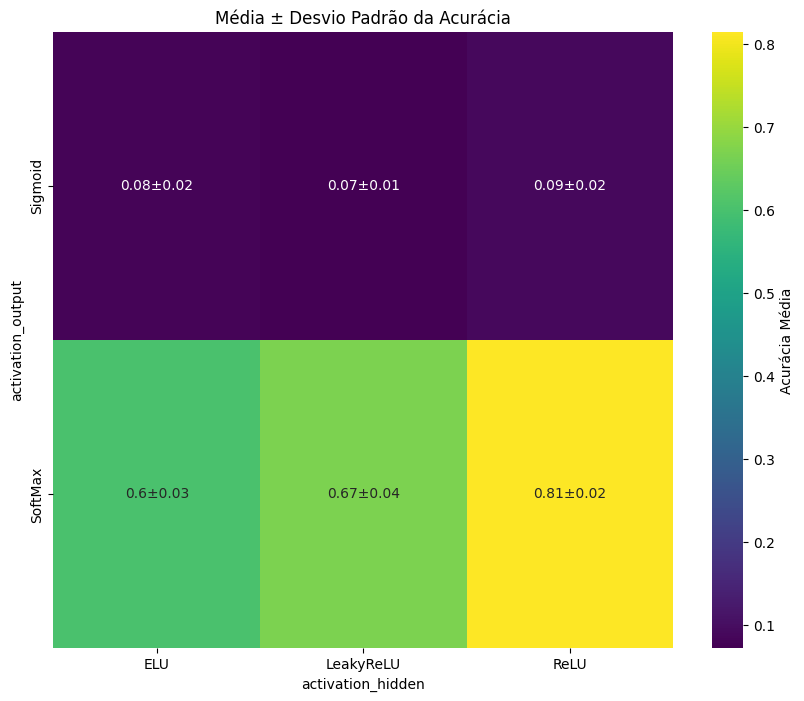

In [46]:
plot_accuracy_heatmap(metrics,'activation_hidden', 'activation_output')

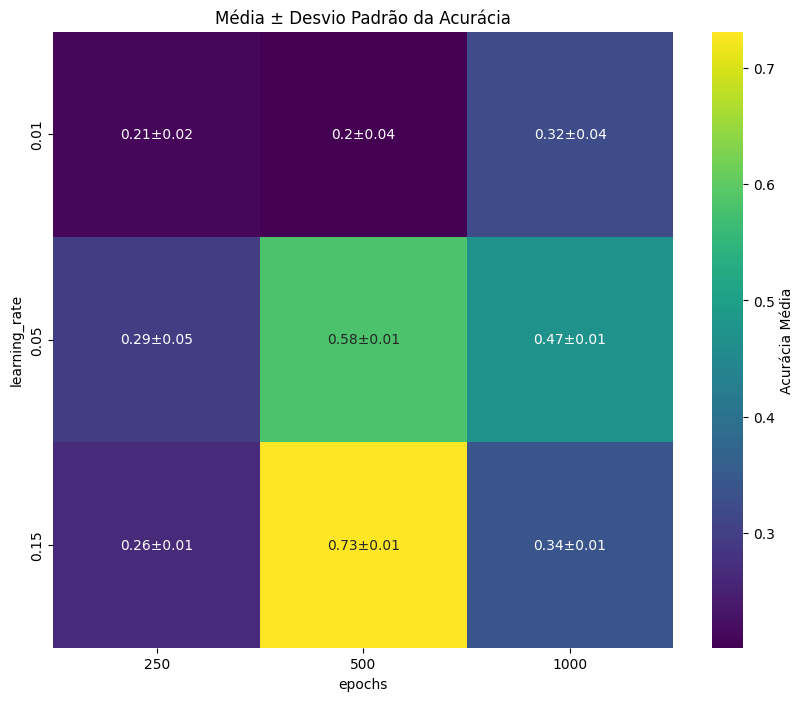

In [47]:
plot_accuracy_heatmap(metrics,'epochs', 'learning_rate')

In [48]:
df = pd.DataFrame(metrics)
id = df['accurancy'].idxmax()
print(df.loc[id])
better_params = df.loc[id]

n_neurons                   16
activation_hidden    LeakyReLU
activation_output      SoftMax
learning_rate             0.15
epochs                    1000
accurancy             0.905043
std                   0.024005
Name: 39, dtype: object


#### Sem Validação Cruzada e Early Stopping

In [50]:
configs = [
    (better_params['n_neurons'], X_train.shape[1], LeakyReLU(alpha=0.01)),
    (y_train.shape[1], better_params['n_neurons'], Softmax() )
]
model = MLP(
    configs,
    BackPropagation(LossCrossEntropy(), better_params['learning_rate'], better_params['epochs'])
)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.15
Number of layers: 2
Architecture:
  Layer 1: 16 neurons - Activation: LeakyReLU
  Layer 2: 26 neurons - Activation: SoftMax



In [51]:
model.train(X_train, y_train)

Epoch 1/1000 - Loss: 3.257918
Epoch 100/1000 - Loss: 1.746516
Epoch 200/1000 - Loss: 0.556888
Epoch 300/1000 - Loss: 0.312841
Epoch 400/1000 - Loss: 0.207680
Epoch 500/1000 - Loss: 0.149615
Epoch 600/1000 - Loss: 0.113186
Epoch 700/1000 - Loss: 0.088597
Epoch 800/1000 - Loss: 0.071373
Epoch 900/1000 - Loss: 0.058932
Epoch 1000/1000 - Loss: 0.049679


In [52]:
y_pred = model.predict(X_test)

In [53]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7923076923076923


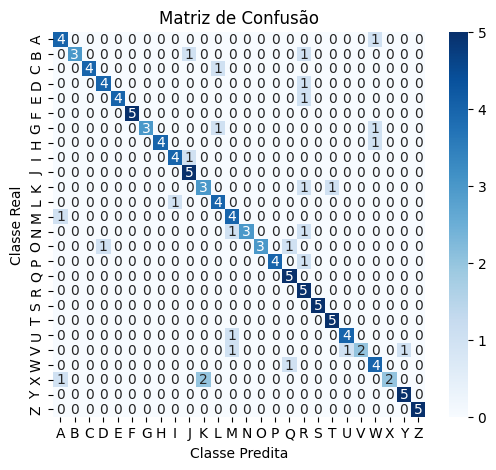

In [54]:
get_confusion_matrix(y_pred, y_test, labels)

### Com Validação cruzada

In [55]:
model = MLP(
    configs,
    BackPropagationCV(LossCrossEntropy(), better_params['learning_rate'], better_params['epochs'])
)

results = model.train(X_train, y_train, k=5)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.15
Number of layers: 2
Architecture:
  Layer 1: 16 neurons - Activation: LeakyReLU
  Layer 2: 26 neurons - Activation: SoftMax

Epoch 1/1000 - Loss: 3.258188
Epoch 100/1000 - Loss: 1.866766
Epoch 200/1000 - Loss: 0.646389
Epoch 300/1000 - Loss: 0.357965
Epoch 400/1000 - Loss: 0.231860
Epoch 500/1000 - Loss: 0.161570
Epoch 600/1000 - Loss: 0.117445
Epoch 700/1000 - Loss: 0.088830
Epoch 800/1000 - Loss: 0.069807
Epoch 900/1000 - Loss: 0.056662
Epoch 1000/1000 - Loss: 0.047125
Epoch 1/1000 - Loss: 3.262488
Epoch 100/1000 - Loss: 1.737630
Epoch 200/1000 - Loss: 0.572793
Epoch 300/1000 - Loss: 0.317315
Epoch 400/1000 - Loss: 0.208069
Epoch 500/1000 - Loss: 0.147173
Epoch 600/1000 - Loss: 0.109505
Epoch 700/1000 - Loss: 0.085171
Epoch 800/1000 - Loss: 0.068576
Epoch 900/1000 - Loss: 0.056748
Epoch 1000/1000 - Loss: 0.047936
Epoch 1/1000 - Loss: 3.269168
Epoch 100/1000 - Loss: 1.63862

In [56]:
acc_avg = np.mean([accurancy(rs['predictions'], rs['targets']) for rs in results])
acc_avg

0.8984615384615384

In [57]:
y_pred = model.predict(X_test)

In [58]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7538461538461538


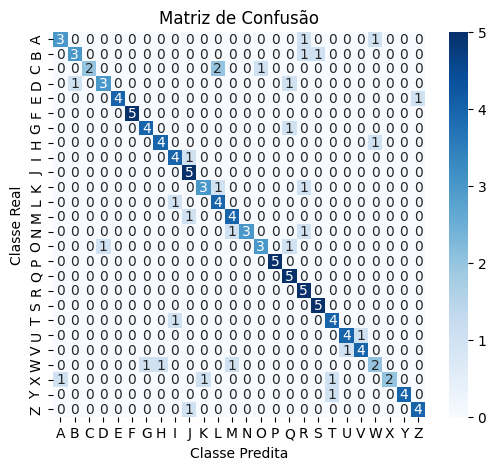

In [59]:
get_confusion_matrix(y_pred, y_test, labels)

# Com Early Stopping

In [60]:
model = MLP(
    configs,
    BackPropagationES(LossCrossEntropy(), better_params['learning_rate'], 300)
)

model.train(X_train, y_train)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 300
Learning rate: 0.15
Number of layers: 2
Architecture:
  Layer 1: 16 neurons - Activation: LeakyReLU
  Layer 2: 26 neurons - Activation: SoftMax

Epoch 1 - Loss: 3.258229
Epoch 100 - Loss: 1.804599
Epoch 200 - Loss: 0.580302
Epoch 300 - Loss: 0.312305
Epoch 400 - Loss: 0.200735
Epoch 500 - Loss: 0.141341
Epoch 600 - Loss: 0.104827
Melhor acurácia
Época 601: 0.8654


In [61]:
y_pred = model.predict(X_test)

In [62]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7769230769230769


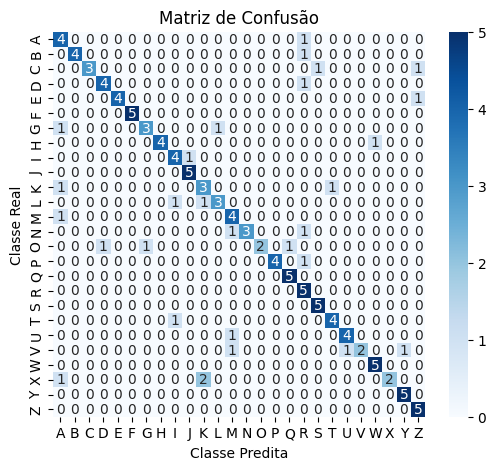

In [63]:
get_confusion_matrix(y_pred, y_test, labels)

<p>Conforme os resultados, a SoftMax foi a função com melhor desempenho e, novamente, todas as funções da camada escondida teve desempenho semelhante. Conforme aumenta a quantidade de neurônios, tende a piorar o desempenho. Em relação ao número de epocas, a situação foi semelhante ao MSE. Learning_rate tbm foi analogo. Contrariando o esperado, o uso de CrossEntropy não melhorou o desempenho, foi semelhante ao MSE.</p>